In [1]:
import numpy as np
import pandas as pd

from src.workflow_manager.paths import data_path, ruleset_path
from src.pipelines.load_and_transform_pipeline import load_and_transform



# ML 
import statsmodels.api as sm
from sklearn.model_selection import train_test_split


from src.modelling.model_functions import build_model
from src.modelling.basemodel import base_model
from src.modelling.model_functions import sigmoid, get_plot_data
from src.modelling.model_plots import plot_model_field





pd.set_option('display.max_columns',None)


### <font color='#f88231'>Load Data and create empty Train Test split DFs</font>


In [2]:
# we need the original Data to generate the column_manager
data_original = load_and_transform(data_path, ruleset_path)

data = data_original.copy()
data['const'] = 1


# empty datasets
X_train, X_test, y_train, y_test = train_test_split(data[['contract_nr', 'const']],data[['contract_nr', 'payment_fault']].set_index('contract_nr'),test_size=0.3, random_state=42)

tts_list = [X_train, X_test, y_train, y_test ]

## <font color='#f88231'>Fit Base Model</font>


                 Generalized Linear Model Regression Results                  
Dep. Variable:          payment_fault   No. Observations:                19562
Model:                            GLM   Df Residuals:                    19523
Model Family:                Binomial   Df Model:                           38
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6926.3
Date:                Fri, 13 Oct 2023   Deviance:                       13853.
Time:                        15:41:45   Pearson chi2:                 1.95e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1843
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -2.97

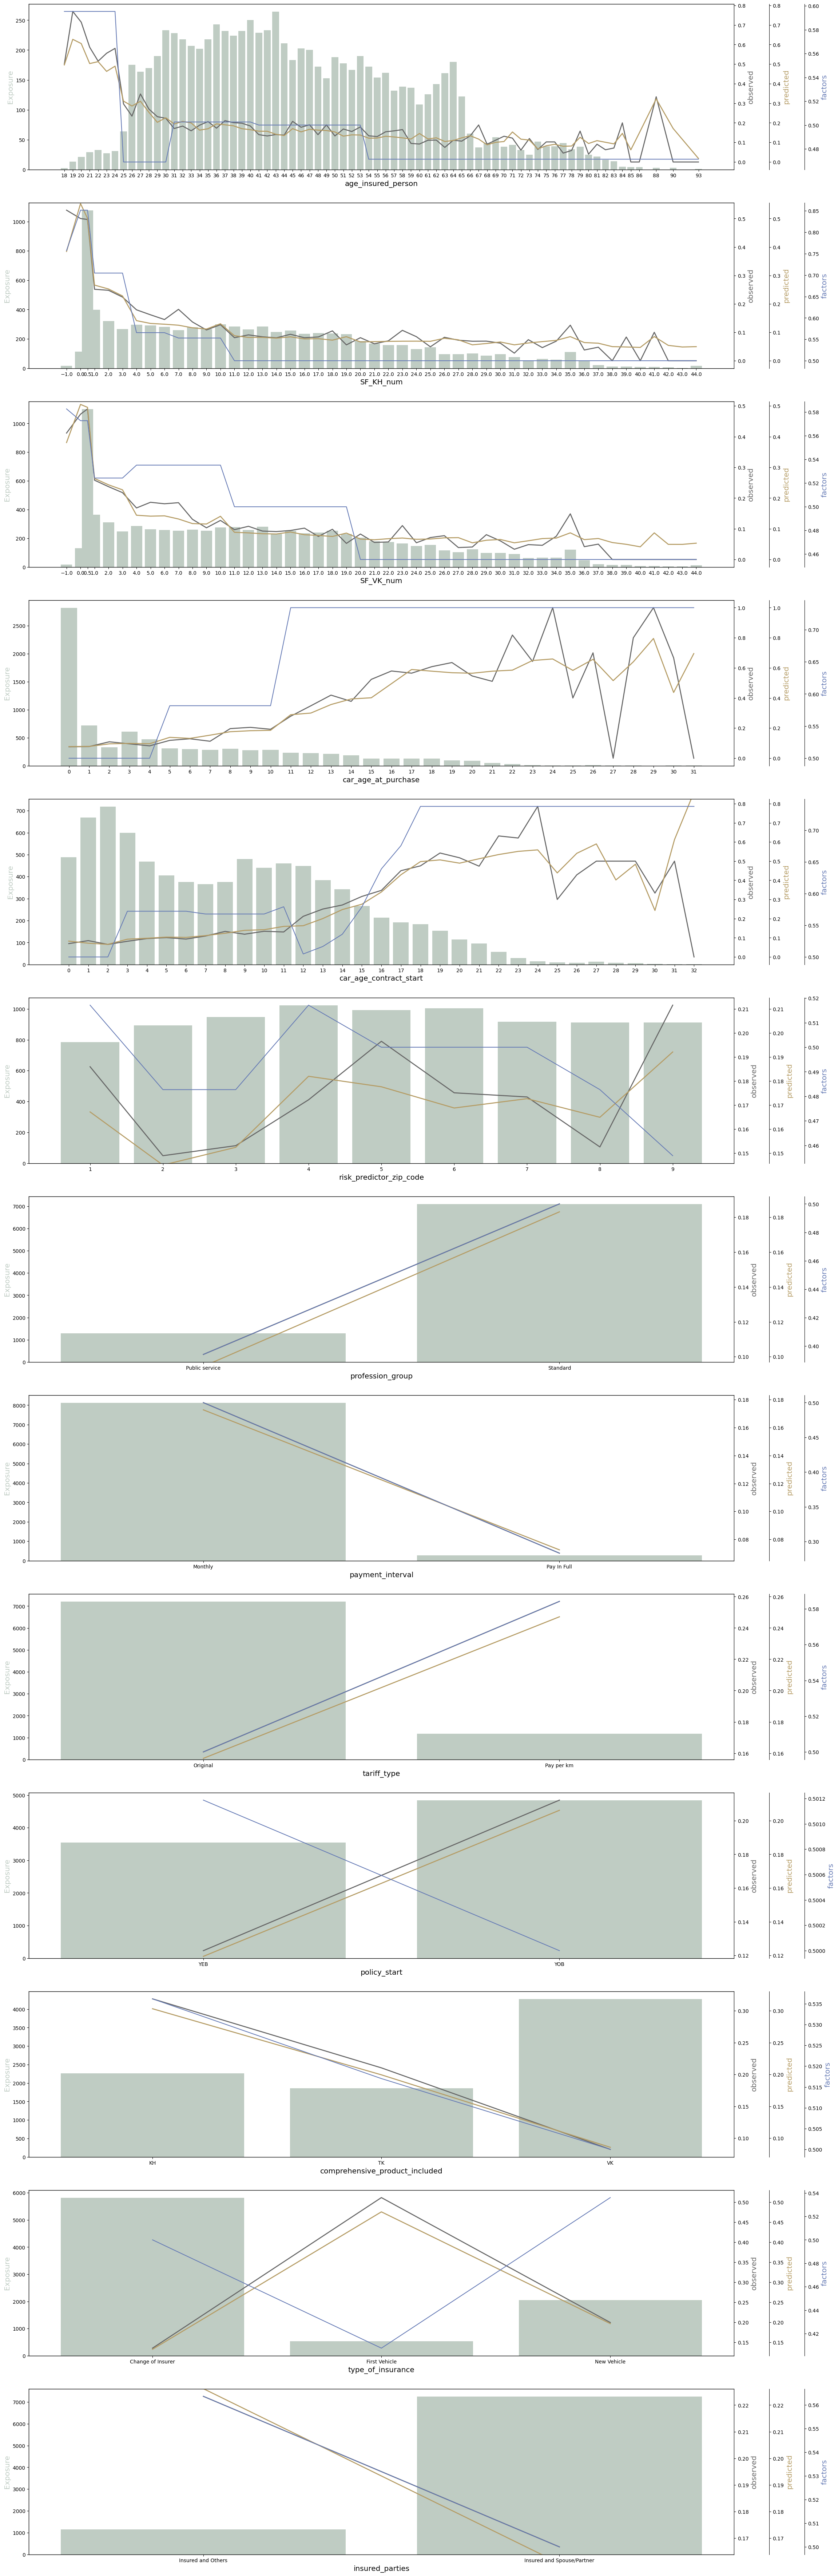

In [4]:
# Save the different columns here
column_manager = {'original' : list(data_original.columns)}
erg = build_model(data, column_manager=column_manager, group_file=base_model , tts_list=tts_list )
print(erg['model'].summary())
plot_model_field(erg, erg['column_manager']['plots'])